# First look at the processCcd output

## Displaying the calibrated exposure

In [1]:
#import the python package related to the butler
import lsst.daf.persistence as dafPersist

# create a butler object associated to the output directory
butler = dafPersist.Butler("/sps/lsst/dev/boutigny/demo/output")

In [2]:
# get the calibrated exposure from the butler
# We first create a dataid dictionary containing the minimal set of informations for the butler to retrieve the file
dataid = {'visit': 40984, 'ccd': 55}

# get the exposure - immediate=True means that the file is immediately read and loaded in memory
#                    immediate=False : the file is read and loaded at first access
calexp = butler.get('calexp', dataid, immediate=True)
calexp

In [3]:
%matplotlib notebook
import lsst.display.matplotlib
import lsst.afw.display as afwDisplay

# RHL trick to display images in matplotlib
afwDisplay.setDefaultBackend("matplotlib")

In [4]:
# an exposure has 3 layers: image, mask and variance
# let's get the image layer
im = calexp.getMaskedImage().getImage()

<IPython.core.display.Javascript object>


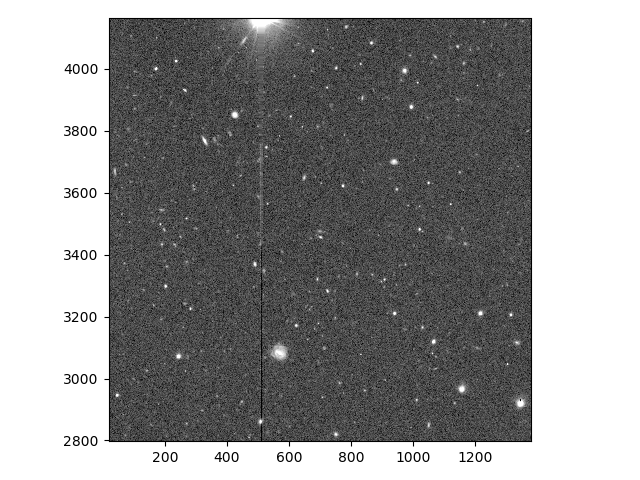

In [37]:
display = afwDisplay.Display(0)
display.setImage(im)
display.scale(algorithm='asinh', min='zscale', Q=3)
display.mtv(im)
display.zoom(3, 700, 3480)

<IPython.core.display.Javascript object>


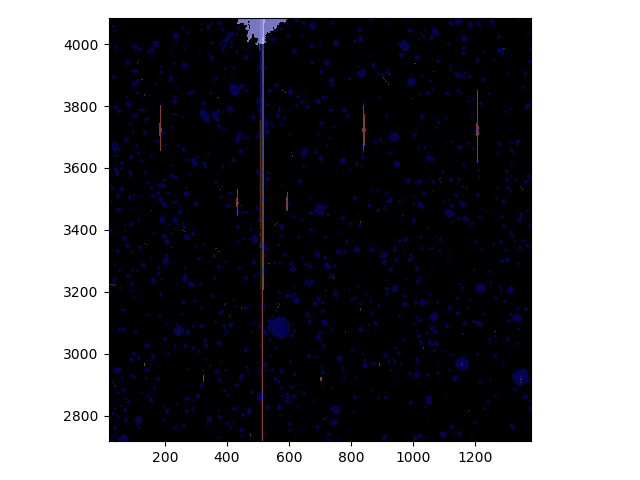

In [29]:
# display the mask layer
mask = calexp.getMaskedImage().getMask()
display = afwDisplay.Display(1)
display.setImage(mask)
display.mtv(mask)
display.zoom(3, 700, 3480)

<IPython.core.display.Javascript object>


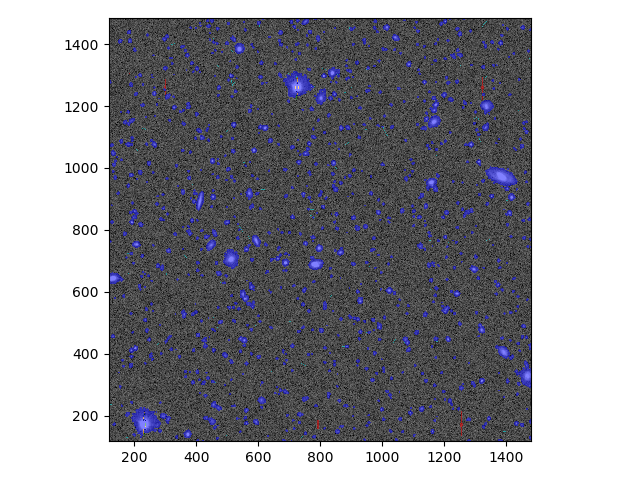

In [32]:
# one can also display the image and the mask layers all together
display = afwDisplay.Display(2)
display.setImage(calexp)
display.scale(algorithm='asinh', min='zscale', Q=3)
# need some tranparency to see the image ! 
display.setMaskTransparency(50)
display.mtv(calexp)
display.zoom(3, 800, 800)

## Look at the source catalog

In [33]:
# get the source catalog from the butler
# We first create a dataid dictionary containing the minimal set of informations for the butler to retrieve the file
dataid = {'visit': 40984, 'ccd': 55}

# get the catalog - immediate=True means that the file is immediately read and loaded in memory
#                    immediate=False : the file is read and loaded at first access
src = butler.get('src', dataid, immediate=True)
src

<class 'lsst.afw.table.source.source.SourceCatalog'>
        id           coord_ra    ... calib_photometryReserved
                       rad       ...                         
----------------- -------------- ... ------------------------
35205224155054081 0.613260824018 ...                    False
35205224155054082 0.613263108924 ...                    False
35205224155054083 0.613263489133 ...                    False
35205224155054084 0.613266048913 ...                    False
35205224155054085 0.613268627517 ...                    False
35205224155054086 0.613260891805 ...                    False
35205224155054087 0.613265235108 ...                    False
35205224155054088 0.613265979129 ...                    False
35205224155054089 0.613265001483 ...                    False
35205224155054090 0.613265053469 ...                    False
              ...            ... ...                      ...
35205224155059458 0.610024892361 ...                    False
35205224155059459

The src catalog in an afw table with 1 column per physics quantity and 1 line per source. 
Let's have a look to the schema of the table in order to see which quantities are available

In [35]:
schema = src.getSchema()
schema.getOrderedNames()

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'calib_detected',
 'calib_psfCandidate',
 'calib_psfUsed',
 'calib_psfReserved',
 'deblend_nChild',
 'deblend_deblendedAsPsf',
 'deblend_psfCenter_x',
 'deblend_psfCenter_y',
 'deblend_psfFlux',
 'deblend_tooManyPeaks',
 'deblend_parentTooBig',
 'deblend_masked',
 'deblend_skipped',
 'deblend_rampedTemplate',
 'deblend_patchedTemplate',
 'deblend_hasStrayFlux',
 'base_GaussianCentroid_x',
 'base_GaussianCentroid_y',
 'base_GaussianCentroid_flag',
 'base_GaussianCentroid_flag_noPeak',
 'base_GaussianCentroid_flag_resetToPeak',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xSigma',
 'base_SdssCentroid_ySigma',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_fla

In [38]:
# Look at coordinates of a given source
print(src[123].get('coord_ra'), src[123].get('coord_dec')'base_PsfFlux_flux',)

0.613174 rad -0.0834234 rad


## We are going to create a ra, dec map of the source

## First method : Using afw tables directly + Old style à la Fortran...

In [48]:
# declare 2 empty lists
ra = []
dec = []

# loop through the table
for s in src :
    ra.append(s.get('coord_ra'))
    dec.append(s.get('coord_dec'))
    
print(min(ra), max(ra), min(dec), max(dec))

0.609979 rad 0.613269 rad -0.0838757 rad -0.0822239 rad


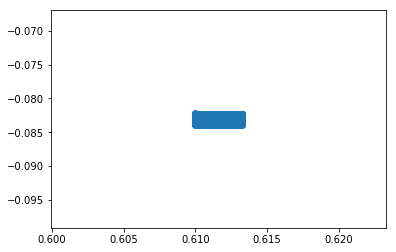

In [64]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

plt.scatter(ra, dec)

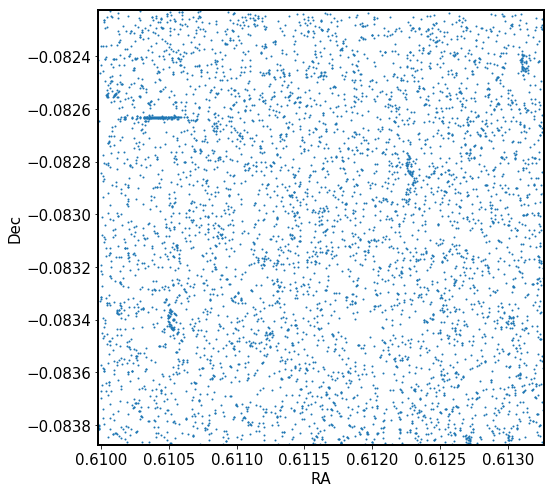

In [71]:
font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 2 
plt.rcParams['mathtext.default'] = 'regular'

fig, (ax) = plt.subplots(ncols=1, figsize=(8,8))
ax.scatter(ra, dec, s=1)
ax.set_xlim([float(min(ra)), float(max(ra))])
ax.set_ylim([float(min(dec)), float(max(dec))])
ax.set_xlabel("RA", fontsize=15)
ax.set_ylabel("Dec", fontsize=15)
ax.tick_params(labelsize=15)


## Look at magnitudes

In [75]:
import lsst.afw.image as afwImage

# get calexp metadata
md = butler.get("calexp_md", dataid, immediate=True)
# get calibration object from the calexp metadata
calib = afwImage.Calib(md)

mag = []
sig = []
for s in src:
    # reject sources with bad PsfFlux (if flag==True, there is a problem)
    if s.get('base_PsfFlux_flag'):
        continue
        
    flux = s.get('base_PsfFlux_flux')
    sigma_flux = s.get('base_PsfFlux_fluxSigma')
    
    # reject sources with negative flux or too faint
    if flux < 0 or flux/sigma_flux < 5: 
        continue
    
    # convert flux into magnitude with error
    mg, err_mg = calib.getMagnitude(flux, sigma_flux)
    mag.append(mg)
    sig.append(err_mg)

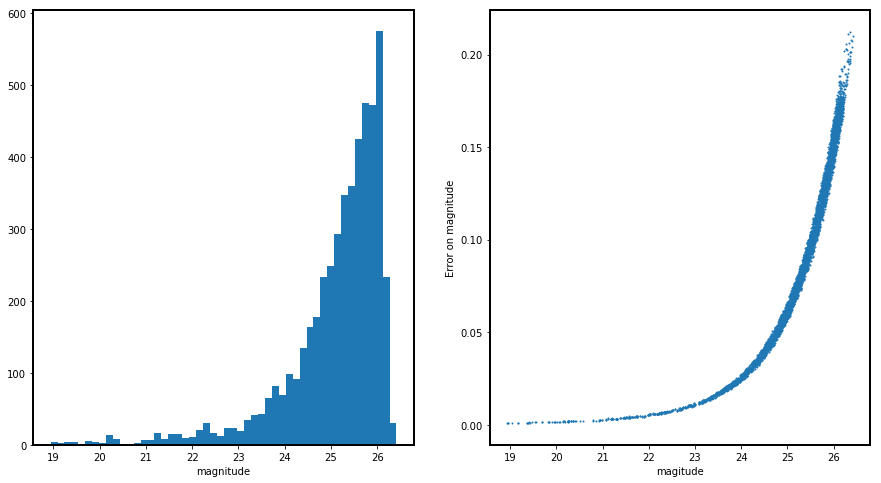

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8))

ax1.hist(mag, bins=50)
ax1.set_xlabel("magnitude")
ax2.scatter(mag, sig, s=1)
ax2.set_xlabel("magitude")
ax2.set_ylabel("Error on magnitude")

## Second method: Convert to astropy

In [96]:
ap_src = src.asAstropy()
ap_src

id,coord_ra,coord_dec,parent,calib_detected,calib_psfCandidate,calib_psfUsed,calib_psfReserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_GaussianCentroid_x,base_GaussianCentroid_y,base_GaussianCentroid_flag,base_GaussianCentroid_flag_noPeak,base_GaussianCentroid_flag_resetToPeak,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,slot_Centroid_xSigma,base_SdssCentroid_ySigma,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianCentroid_flag_badInitialCentroid,base_GaussianFlux_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianCentroid_flag_badInitialCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianCentroid_flag_badInitialCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianCentroid_flag_badInitialCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmSourceMom

In [110]:
from astropy.table import Table

# selection flag
select =  (ap_src['base_PsfFlux_flag'] == False) & (ap_src['base_PsfFlux_flux'] > 0)
select &= (ap_src['ext_photometryKron_KronFlux_flag'] == False) & (ap_src['ext_photometryKron_KronFlux_flux'] > 0)

# convert flux to magnitude in a single instruction
mPsf, sPsf = calib.getMagnitude(ap_src['base_PsfFlux_flux'][select], ap_src['base_PsfFlux_fluxSigma'][select])
mKron, sKron = calib.getMagnitude(ap_src['ext_photometryKron_KronFlux_flux'][select], 
                                  ap_src['ext_photometryKron_KronFlux_fluxSigma'][select])

# keep only the good rows
ap_src = ap_src[select]

# add columns in astropy table with magnitude and error on magnitudefor both Psf and Kron
ap_src['PsfMagnitude'] = mPsf
ap_src['PsfMagnitudeErr'] = sPsf
ap_src['KronMagnitude'] = mKron
ap_src['KronMagnitudeErr'] = sKron

# select stars
stars =  (ap_src['base_ClassificationExtendedness_flag'] == False) 
stars &= (ap_src['base_ClassificationExtendedness_value'] < 0.5)

# select galaxies
galaxies =  (ap_src['base_ClassificationExtendedness_flag'] == False) 
galaxies &= (ap_src['base_ClassificationExtendedness_value'] > 0.5)


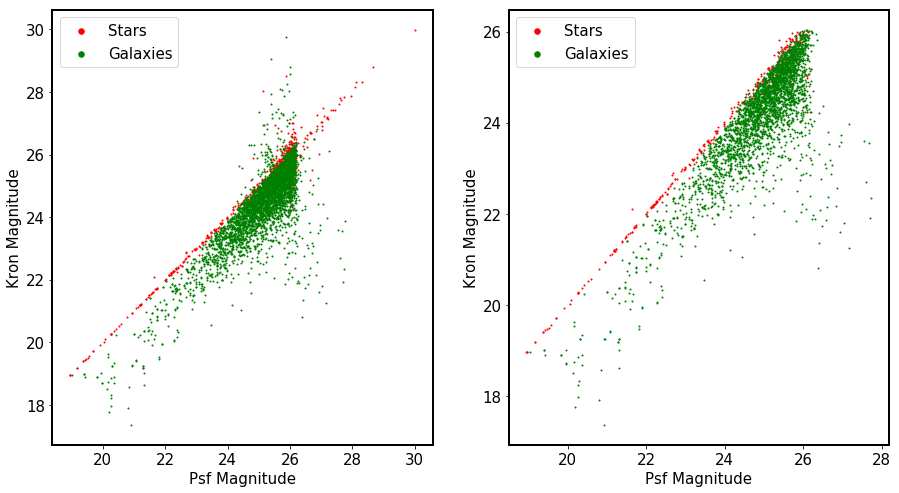

In [130]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8))

ax1.scatter(ap_src['PsfMagnitude'][stars], ap_src['KronMagnitude'][stars], s=1, c='r', label='Stars')
ax1.scatter(ap_src['PsfMagnitude'][galaxies], ap_src['KronMagnitude'][galaxies], s=1, c='g', label='Galaxies')
ax1.set_xlabel('Psf Magnitude', fontsize=15)
ax1.set_ylabel('Kron Magnitude', fontsize=15)
lgnd = ax1.legend(fontsize=15)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax1.tick_params(labelsize=15)

# add a filter to cleanup faint sources
clean = ap_src['ext_photometryKron_KronFlux_flux']/ap_src['ext_photometryKron_KronFlux_fluxSigma'] > 5
ax2.scatter(ap_src['PsfMagnitude'][(stars) & (clean)], ap_src['KronMagnitude'][(stars) & (clean)], s=1, c='r', label='Stars')
ax2.scatter(ap_src['PsfMagnitude'][(galaxies) & (clean)], ap_src['KronMagnitude'][(galaxies) & (clean)], s=1, c='g', label='Galaxies')
ax2.set_xlabel('Psf Magnitude', fontsize=15)
ax2.set_ylabel('Kron Magnitude', fontsize=15)
lgnd = ax2.legend(fontsize=15)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax2.tick_params(labelsize=15)
